In [830]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
# set style for seaborn
sns.set(rc={"figure.figsize":(20, 6)})
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {"grid.linestyle": ":"})


In [683]:
df_1 = pd.read_excel("buyers1.xls")
df_1.head()

,Date,VTPC,EPIPE,PVURC,PVD,SVCRC,MaxEPI,MinEPI
0,05.04.2020,2011051.007,1136.09,400667.334,1464802.233,2756.988,1399.90,863.24
1,06.04.2020,2053895.126,1279.86,400667.334,1504613.045,2682.265,1597.00,843.48
2,07.04.2020,2041359.284,1121.92,400667.334,1496706.986,2951.107,1417.78,806.17
3,08.04.2020,2033106.623,1060.13,400667.334,1487836.262,2922.426,1391.27,747.74
4,09.04.2020,2023396.298,1184.06,400667.334,1477808.105,3190.166,1427.30,780.86


In [684]:
styled_df = df_1.head().style.background_gradient()
styled_df

,Date,VTPC,EPIPE,PVURC,PVD,SVCRC,MaxEPI,MinEPI
0,05.04.2020,2011051.007000,1136.090000,400667.334000,1464802.233000,2756.988000,1399.900000,863.240000
1,06.04.2020,2053895.126000,1279.860000,400667.334000,1504613.045000,2682.265000,1597.000000,843.480000
2,07.04.2020,2041359.284000,1121.920000,400667.334000,1496706.986000,2951.107000,1417.780000,806.170000
3,08.04.2020,2033106.623000,1060.130000,400667.334000,1487836.262000,2922.426000,1391.270000,747.740000
4,09.04.2020,2023396.298000,1184.060000,400667.334000,1477808.105000,3190.166000,1427.300000,780.860000


In [685]:
df_2 = pd.read_excel("buyers2.xls")
df_2.tail()

,Date,VTPC,EPIPE,PVURC,PVD,SVCRC,MaxEPI,MinEPI
1117,27.04.2023,599364.625,1421.82,94046.655,488932.863,189.990,1502.31,1300.50
1118,28.04.2023,593546.501,1438.43,94046.655,482692.069,535.197,1516.17,1329.97
1119,29.04.2023,588059.233,1585.05,94046.655,476521.841,353.089,1674.27,1493.82
1120,30.04.2023,588283.756,1609.28,94046.655,476665.673,649.126,1683.24,1507.08
1121,01.05.2023,589201.895,1637.49,83211.935,489724.443,236.108,1742.33,1512.35


In [686]:
styled_df = df_2.head().style.background_gradient()
styled_df

,Date,VTPC,EPIPE,PVURC,PVD,SVCRC,MaxEPI,MinEPI
0,05.04.2020,522796.483000,1030.620000,85518.334000,418946.716000,613.811000,1087.050000,954.870000
1,06.04.2020,526922.971000,1026.380000,85518.334000,423502.349000,527.945000,1170.340000,866.920000
2,07.04.2020,524266.260000,959.700000,85518.334000,420832.412000,816.114000,1064.310000,851.460000
3,08.04.2020,522847.708000,888.510000,85518.334000,419700.103000,611.128000,944.780000,841.710000
4,09.04.2020,533857.529000,887.760000,85518.334000,430573.229000,615.296000,955.370000,829.910000


In [687]:
# create the new column price and transform datatype of column 'Date'
df_1['Price'] = df_1['EPIPE']
df_1['Date'] = pd.to_datetime(df_1['Date'], dayfirst=True)
df_1 = df_1[['Date', 'Price']]

df_2['Price'] = df_2['EPIPE']
df_2['Date'] = pd.to_datetime(df_2['Date'], dayfirst=True)
df_2 = df_2[['Date', 'Price']]

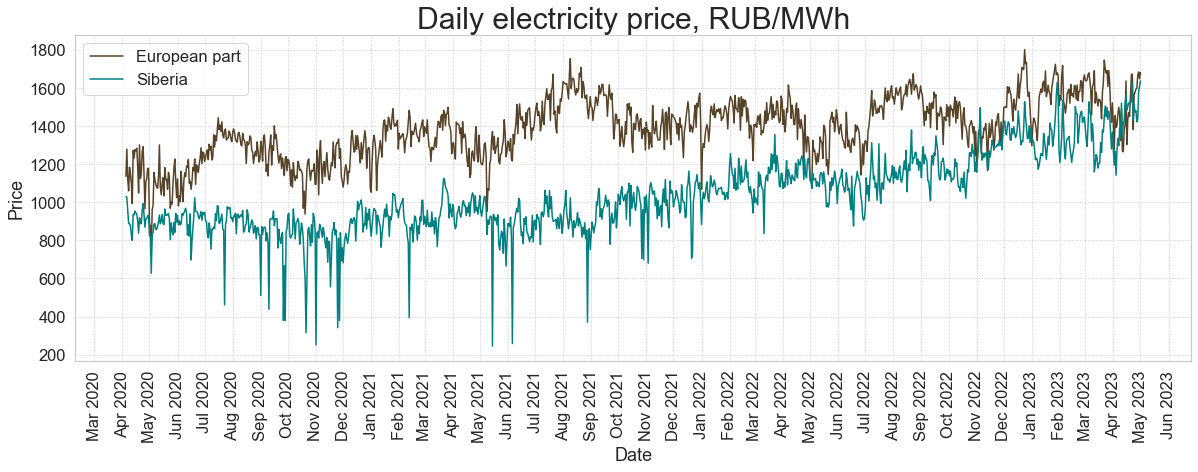

In [688]:
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.tick_params(axis='x', rotation=90)

sns.lineplot(x=df_1["Date"], y=df_1["Price"], label="European part", color="#574327", ax=ax)
sns.lineplot(x=df_2["Date"], y=df_2["Price"], label="Siberia", color="#008080", ax=ax)

ax.set_title("Daily electricity price, RUB/MWh", size=30)

plt.savefig('price.png', dpi=300, bbox_inches='tight')
plt.show()

### Create time series for both data frames to visualize their components

In [689]:
ts_1 = df_1.set_index("Date")
result_1 = seasonal_decompose(ts_1, model="additive")

ts_2 = df_2.set_index("Date")
result_2 = seasonal_decompose(ts_2, model="additive")

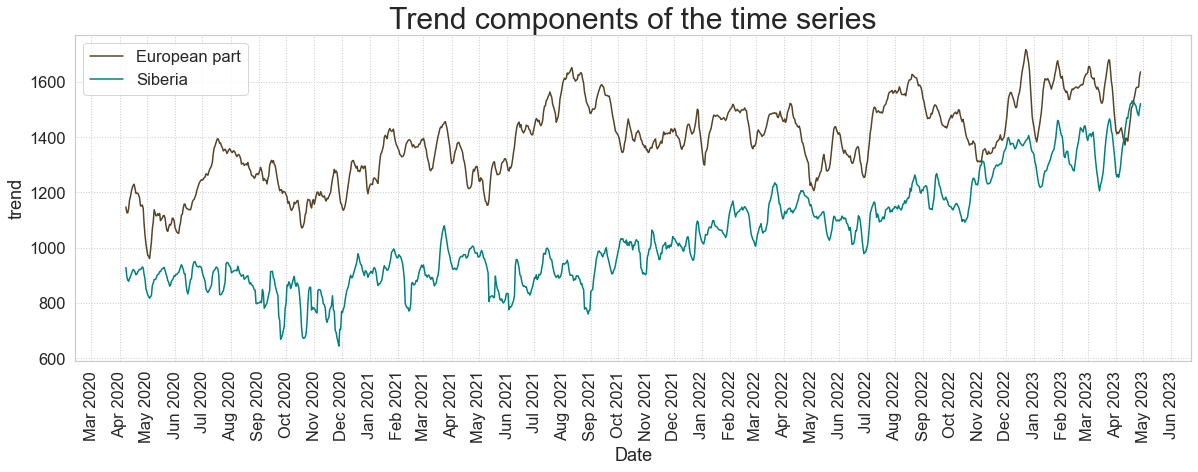

In [690]:
# trend component
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.tick_params(axis='x', rotation=90)

sns.lineplot(x=result_1.trend.index, y=result_1.trend, label="European part", color="#574327", ax=ax)
sns.lineplot(x=result_2.trend.index, y=result_2.trend, label="Siberia", color="#008080", ax=ax)
ax.set_title("Trend components of the time series", size=30)

plt.savefig('trend.png', dpi=300, bbox_inches='tight')
plt.show()

In [691]:
# agrigate price monthly to analyse seasonality
df_season_1 = df_1.set_index("Date")
df_season_1 = df_season_1.resample("MS").mean()
result_season_1 = seasonal_decompose(df_season_1, model="additive")

df_season_2 = df_2.set_index("Date")
df_season_2 = df_season_2.resample("MS").mean()
result_season_2 = seasonal_decompose(df_season_2, model="additive")

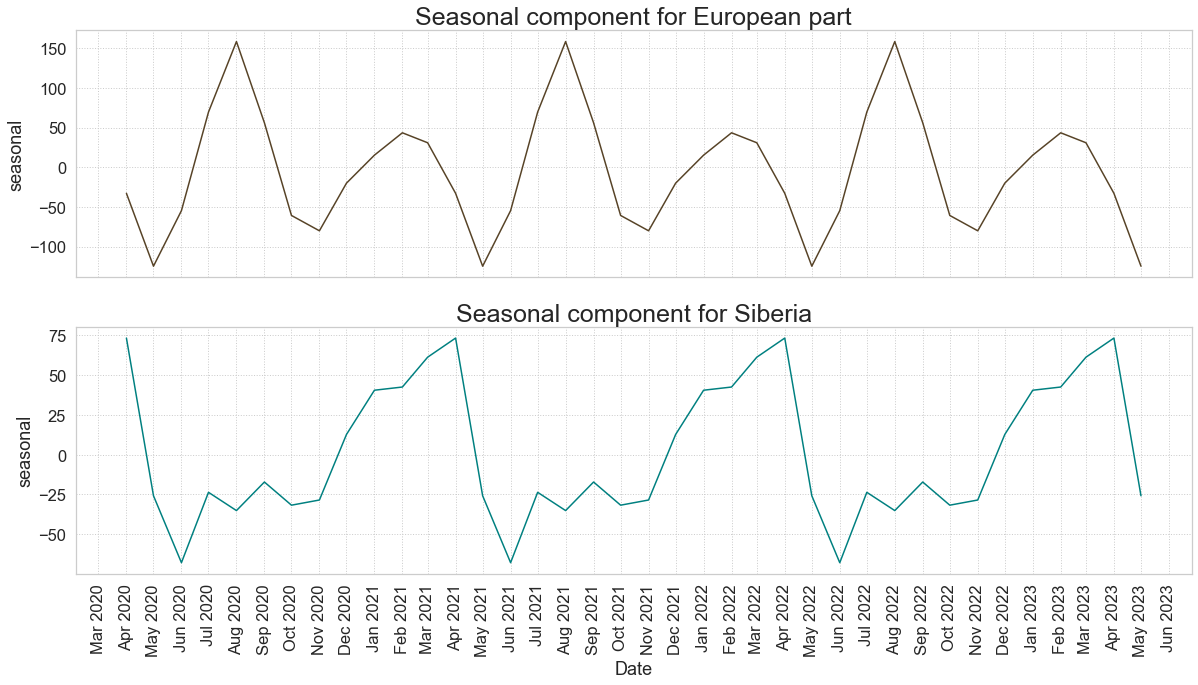

In [692]:
# seasonality component
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax[0].tick_params(axis='x', rotation=90)

sns.lineplot(x=result_season_1.seasonal.index, y=result_season_1.seasonal, color="#574327", ax=ax[0])
ax[0].set_title('Seasonal component for European part', size=25)

ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax[1].tick_params(axis='x', rotation=90)

sns.lineplot(x=result_season_2.seasonal.index, y=result_season_2.seasonal, color="#008080", ax=ax[1])
ax[1].set_title('Seasonal component for Siberia', size=25)

plt.savefig('season.png', dpi=300, bbox_inches='tight')
plt.show()

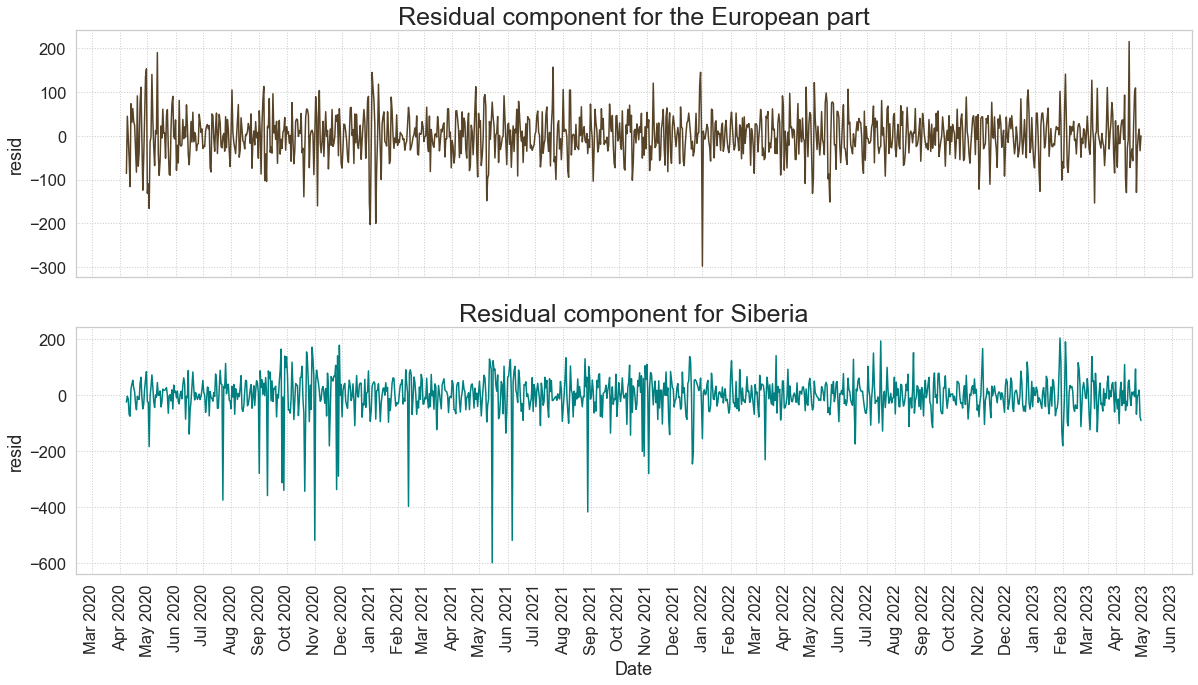

In [693]:
# residual component
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

sns.lineplot(x=result_1.resid.index, y=result_1.resid, color="#574327", ax=ax[0])
ax[0].set_title('Residual component for the European part', size=25)

ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax[1].tick_params(axis='x', rotation=90)

sns.lineplot(x=result_2.resid.index, y=result_2.resid, color="#008080", ax=ax[1])
ax[1].set_title('Residual component for Siberia', size=25)

plt.savefig('residual.png', dpi=300, bbox_inches='tight')
plt.show()

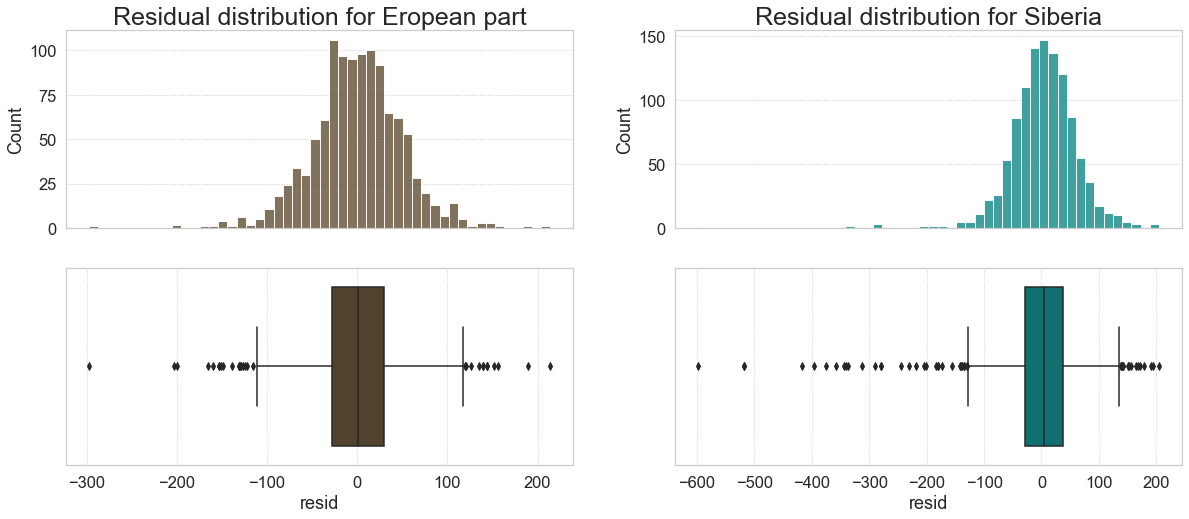

In [694]:
# residual component distribution
fig, ax = plt.subplots(2, 2, figsize=(20, 8))

sns.histplot(result_1.resid, bins=50, color="#574327", ax=ax[0][0])
ax[0][0].set_title("Residual distribution for Eropean part", size=25)
ax[0][0].set_xticks([])
ax[0][0].set_xlabel("")

sns.histplot(result_2.resid, bins=50, color="#008080", ax=ax[0][1])
ax[0][1].set_title("Residual distribution for Siberia", size=25)
ax[0][1].set_xticks([])
ax[0][1].set_xlabel("")

sns.boxplot(x=result_1.resid, color="#574327", ax=ax[1][0])
sns.boxplot(x=result_2.resid, color="#008080", ax=ax[1][1])

plt.savefig('residualdist.png', dpi=300, bbox_inches='tight')
plt.show()

In [695]:
# check time series stationarity with The Augmented Dickey-Fuller (ADF) test
resid_1 = adfuller(result_1.resid.dropna())
resid_2 = adfuller(result_2.resid.dropna())

print('resid_1')
print('ADF Statistic: {:.3f}'.format(resid_1[0]))
print('p-value: {:.3f}'.format(resid_1[1]))
print('Critical Values:')
for key, value in resid_1[4].items():
    print('\t{}: {:.3f}'.format(key, value))
    
print('resid_2')
print('ADF Statistic: {:.3f}'.format(resid_2[0]))
print('p-value: {:.3f}'.format(resid_2[1]))
print('Critical Values:')
for key, value in resid_2[4].items():
    print('\t{}: {:.3f}'.format(key, value))

resid_1
ADF Statistic: -13.624
p-value: 0.000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
resid_2
ADF Statistic: -13.219
p-value: 0.000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


## Statistical methods for anomaly detection
#### all values more or less then three sigma are going to be considered as anomalies

In [696]:
from distribution_anomaly_detectors import OutlierDetector

In [697]:
# First time series
# find anomalies using method OutlierDetector and convert them to pandas DataFrame
anomalies_1 = OutlierDetector(result_1.resid).get_labels()
df_anomalies_1 = pd.DataFrame(anomalies_1)
stat_anom_europe = df_anomalies_1 # for the following prediction

# convert time series residual to pandas DataFrame and add anomalies to DataFrame as a column
df_resid_1 = pd.DataFrame(result_1.resid)
df_resid_1['anomaly'] = df_anomalies_1['label']

# # create separate pandas DataFrame for anomalies for scatter plot
markers_1 = df_resid_1.loc[~df_resid_1['anomaly'].isna(), ['resid']]

# Second time series
# find anomalies using method OutlierDetector and convert them to pandas DataFrame
anomalies_2 = OutlierDetector(result_2.resid).get_labels()
df_anomalies_2 = pd.DataFrame(anomalies_2)
stat_anom_siberia = df_anomalies_2 # for the following prediction

# convert time series residual to pandas DataFrame and add anomalies to DataFrame as a column
df_resid_2 = pd.DataFrame(result_2.resid)
df_resid_2['anomaly'] = df_anomalies_2['label']

# create separate pandas DataFrame for anomalies for scatter plot
markers_2 = df_resid_2.loc[~df_resid_2['anomaly'].isna(), ['resid']]

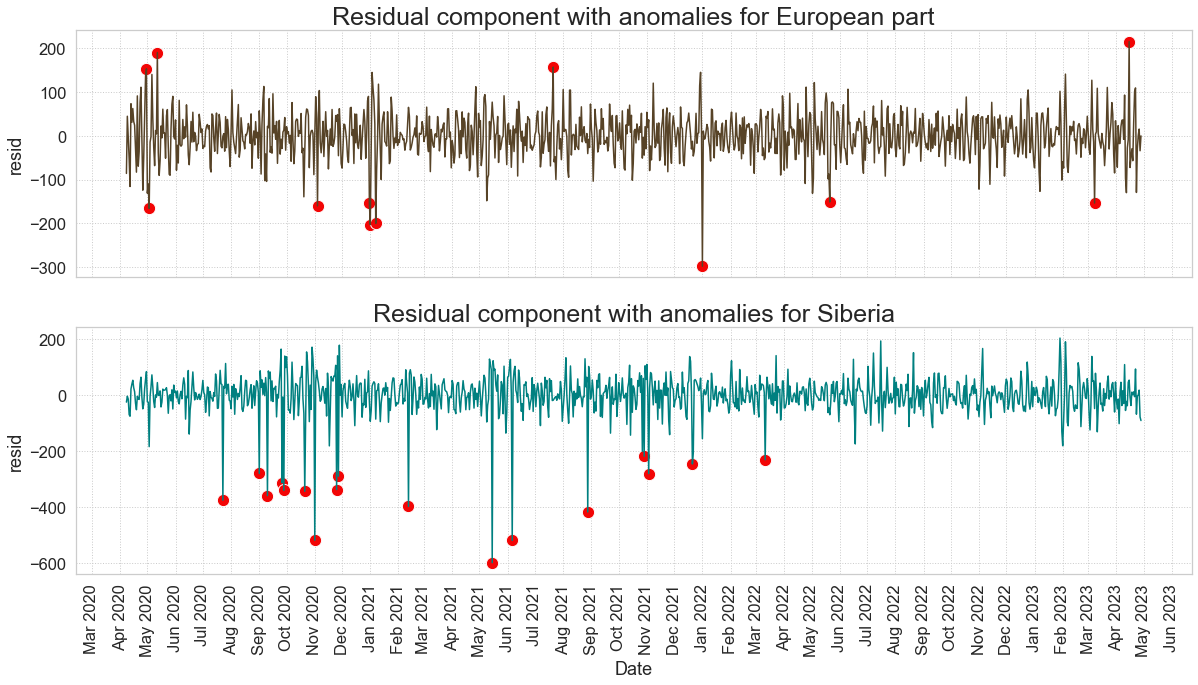

In [698]:
# plot residual component together with its anomalies
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

sns.lineplot(x=result_1.resid.index, y=result_1.resid, color="#574327", ax=ax[0])
sns.scatterplot(x=markers_1.index, y=markers_1['resid'], s=150, color="#f20505", ax=ax[0])
ax[0].set_title('Residual component with anomalies for European part', size=25)

ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax[1].tick_params(axis='x', rotation=90)

sns.lineplot(x=result_2.resid.index, y=result_2.resid, color="#008080", ax=ax[1])
sns.scatterplot(x=markers_2.index, y=markers_2['resid'], s=150, color="#f20505", ax=ax[1])
ax[1].set_title('Residual component with anomalies for Siberia', size=25)

plt.savefig('statanomalies.png', dpi=300, bbox_inches='tight')
plt.show()

## Anomalies detection by Isolation Forest

In [699]:
# prepare and normalize the data of the first time series before training
scaler = StandardScaler()
resid_1 = pd.DataFrame(scaler.fit_transform(result_1.resid.dropna().values.reshape(-1, 1)), columns=['resid'])

# train and fit the model
model = IsolationForest(contamination=0.05)
model.fit(resid_1)

# create separate dataframe for anomalies
df_1 = pd.DataFrame(result_1.resid.dropna())
df_1['anomaly'] = model.predict(resid_1)
forest_anom_europe = df_1['anomaly'] # for the following prediction

markers_1 = df_1.loc[df_1.anomaly == -1, ['resid']]

# prepare and normalize the data of the second time series before training
scaler = StandardScaler()
resid_2 = pd.DataFrame(scaler.fit_transform(result_2.resid.dropna().values.reshape(-1, 1)), columns=['resid'])

# train and fit the model
model = IsolationForest(contamination=0.05)
model.fit(resid_2)

# create separate dataframe for anomalies
df_2 = pd.DataFrame(result_2.resid.dropna())
df_2['anomaly'] = model.predict(resid_2)
forest_anom_siberia = df_2['anomaly'] # for the following prediction

markers_2 = df_2.loc[df_2.anomaly == -1, ['resid']]

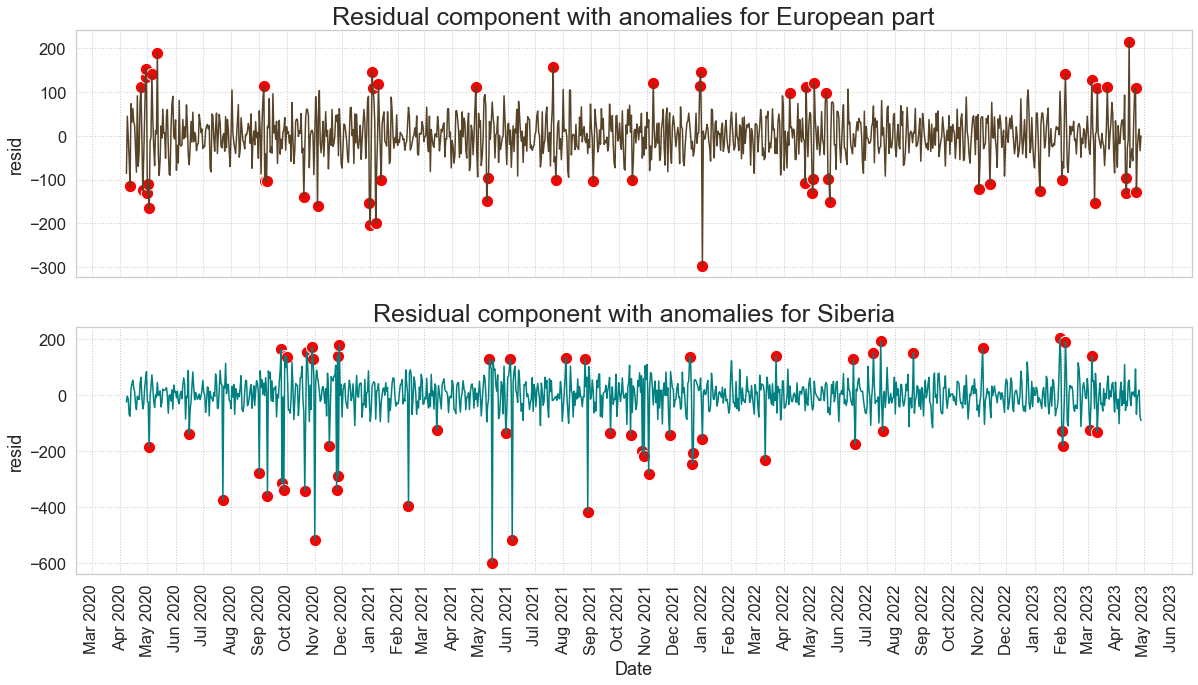

In [700]:
# plot residual component together with its anomalies
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

sns.lineplot(x=result_1.resid.index, y=result_1.resid, color="#574327", ax=ax[0])
sns.scatterplot(x=markers_1.index, y=markers_1['resid'], s=150, color="#f20505", ax=ax[0])
ax[0].set_title('Residual component with anomalies for European part', size=25)

ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax[1].tick_params(axis='x', rotation=90)

sns.lineplot(x=result_2.resid.index, y=result_2.resid, color="#008080", ax=ax[1])
sns.scatterplot(x=markers_2.index, y=markers_2['resid'], s=150, color="#f20505", ax=ax[1])
ax[1].set_title('Residual component with anomalies for Siberia', size=25)

plt.savefig('forestanomalies.png', dpi=300, bbox_inches='tight')
plt.show()

## Anomalies detection by K-means

In [724]:
# prepare dataframes for the next caulculations
df_1 = pd.DataFrame(result_1.resid.dropna())
df_features_1 = df_1.copy()
# create new features for the dataset
# df_features_1['previous_7'] = df_features_1['resid'].shift(periods=7)

df_features_1['previous_30'] = df_features_1['resid'].shift(periods=30)
df_features_1.dropna(inplace=True)

df_2 = pd.DataFrame(result_2.resid.dropna())
df_features_2 = df_2.copy()
# create new features for the dataset
# df_features_2['previous_7'] = df_features_2['resid'].shift(periods=7)

df_features_2['previous_30'] = df_features_2['resid'].shift(periods=30)
df_features_2.dropna(inplace=True) 

In [725]:
# !pip uninstall threadpoolctl
# !pip install threadpoolctl
# !pip install --upgrade threadpoolctl

C:\Users\sndbo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\sndbo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


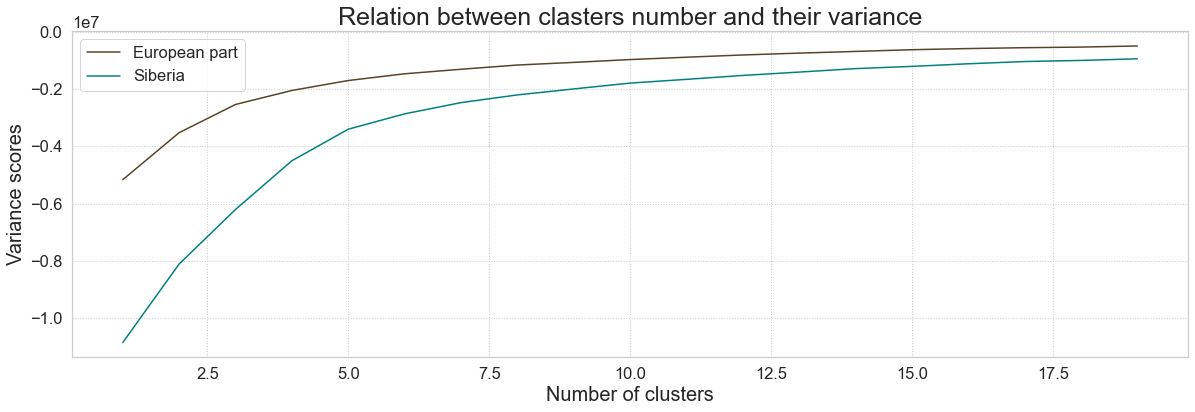

In [726]:
# find optimal number of clusters by Elbow's rule
n_cls = range(1, 20)

# calculate and collect variance for different number of cluster2
kmeans_1 = [KMeans(n_clusters=i).fit(df_features_1) for i in n_cls]
scores_1 = [kmeans_1[i].score(df_features_1) for i in range(len(kmeans_1))]

kmeans_2 = [KMeans(n_clusters=i).fit(df_features_2) for i in n_cls]
scores_2 = [kmeans_2[i].score(df_features_2) for i in range(len(kmeans_2))]

# plot the number of clusters regards with scores
fig, ax = plt.subplots(figsize=(20, 6))
sns.lineplot(x=n_cls, y=scores_1, color="#574327", label="European part", ax=ax)
sns.lineplot(x=n_cls, y=scores_2, color="#008080", label="Siberia", ax=ax)
ax.set_title('Relation between clasters number and their variance', size=25)
ax.set_xlabel('Number of clusters', fontsize=20)
ax.set_ylabel('Variance scores', fontsize=20)

plt.savefig('clustervar.png', dpi=300, bbox_inches='tight')
plt.show()

In [727]:
# normalize dataframe for next calculation
df_val_1 = df_features_1.values
df_std_1 = StandardScaler().fit_transform(df_val_1)

df_val_2 = df_features_2.values
df_std_2 = StandardScaler().fit_transform(df_val_2)

# convert normalized data to pandas dataframe
data_1 = pd.DataFrame(df_std_1)
data_2 = pd.DataFrame(df_std_2)

# train the models
model_1 = KMeans(n_clusters=5).fit(data_1)
model_2 = KMeans(n_clusters=7).fit(data_2)

In [728]:
def getDistanceByPoint(data, model):
    """
    the function takes dataframe and trained model and return pandas series with
    distance between each point and its cluster's center
    data: pandas dataframe
    model: trained model
    """
    distance = pd.Series(dtype='object')
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i]=np.linalg.norm(Xa-Xb)
    return distance

In [729]:
# create column with clusters predicted
df_features_1.reset_index(inplace=True)
df_features_1['cluster'] = model_1.predict(data_1)
df_features_1.index = data_1.index

# find anomalies in the dataset
dist_1 = getDistanceByPoint(data_1, model_1)
threshold_1 = np.percentile(dist_1, 95)
df_features_1['anomaly'] = (dist_1 >= threshold_1).astype(int)
kmeans_anom_europe = df_features_1[['Date', 'anomaly']].set_index('Date') # for the following prediction

markers_1 = df_features_1.loc[df_features_1.anomaly == 1, ['Date', 'resid']] 

# create column with clusters predicted
df_features_2.reset_index(inplace=True)
df_features_2['cluster'] = model_2.predict(data_2)
df_features_2.index = data_2.index

# find anomalies in the dataset
dist_2 = getDistanceByPoint(data_2, model_2)
threshold_2 = np.percentile(dist_2, 95)
df_features_2['anomaly'] = (dist_2 >= threshold_2).astype(int)
kmeans_anom_siberia = df_features_2[['Date', 'anomaly']].set_index('Date') # for the following prediction

markers_2 = df_features_2.loc[df_features_2.anomaly == 1, ['Date', 'resid']]

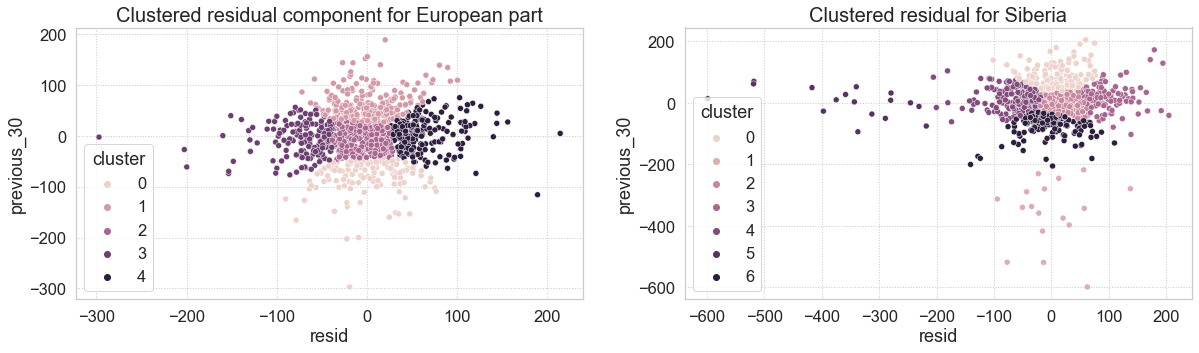

In [386]:
# plot residual component together with its anomalies
anomalies_1 = df_features_1[["resid", "previous_30", "cluster"]]
anomalies_2 = df_features_2[["resid", "previous_30", "cluster"]]

fig, ax = plt.subplots(1, 2, figsize=(20,5))

sns.scatterplot(data=anomalies_1, x="resid", y="previous_30", hue="cluster", ax=ax[0])
ax[0].set_title('Clustered residual component for European part', size=20)

sns.scatterplot(data=anomalies_2, x="resid", y="previous_30", hue="cluster", ax=ax[1])
ax[1].set_title('Clustered residual for Siberia', size=20)

plt.savefig('kmeansclusters.png', dpi=300, bbox_inches='tight')
plt.show()

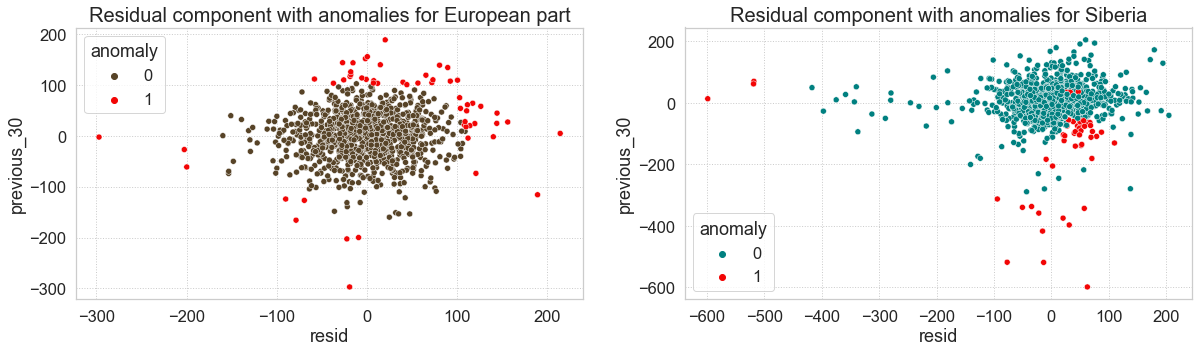

In [387]:
# plot residual component together with its anomalies
anomalies_1 = df_features_1[["resid", "previous_30", "anomaly"]]
anomalies_2 = df_features_2[["resid", "previous_30", "anomaly"]]

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.scatterplot(data=anomalies_1, x="resid", y="previous_30", hue="anomaly",
                palette={0: "#574327", 1: "#f20505"}, ax=ax[0])
ax[0].set_title('Residual component with anomalies for European part', size=20)

sns.scatterplot(data=anomalies_2, x="resid", y="previous_30", hue="anomaly",
                palette={0: "#008080", 1: "#f20505"}, ax=ax[1])
ax[1].set_title('Residual component with anomalies for Siberia', size=20)

plt.savefig('clusteranomalies.png', dpi=300, bbox_inches='tight')
plt.show()

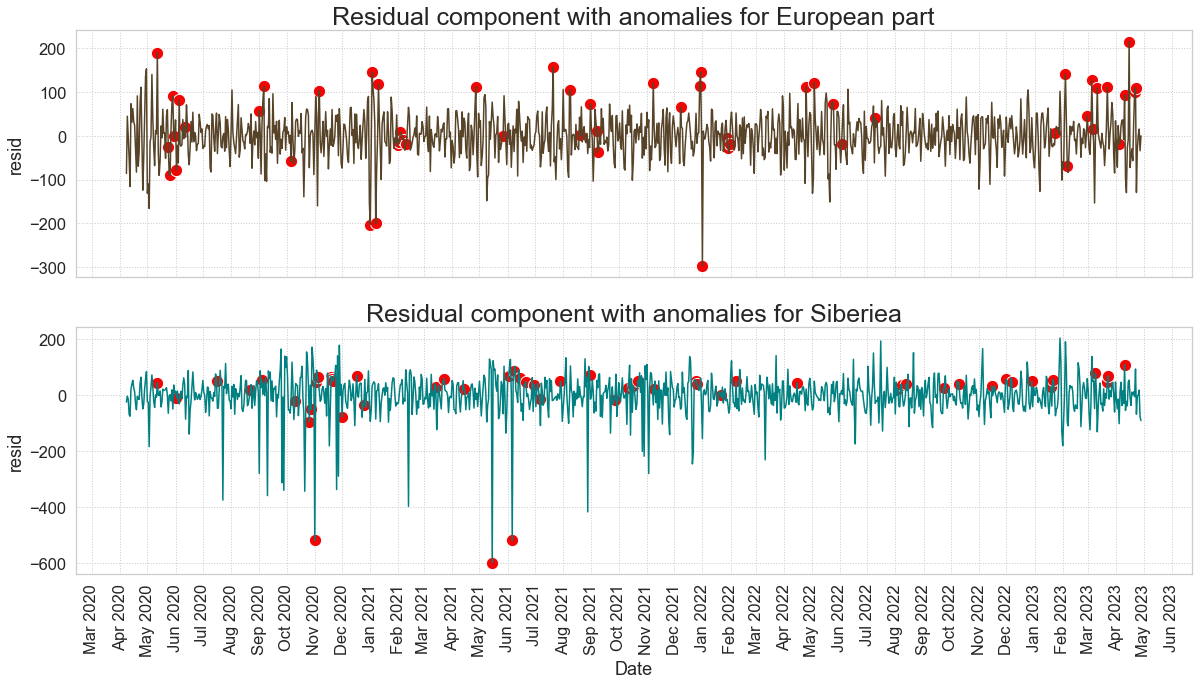

In [389]:
# plot residual component together with its anomalies
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

sns.lineplot(x=result_1.resid.index, y=result_1.resid, color="#574327", ax=ax[0])
sns.scatterplot(x=markers_1['Date'], y=markers_1['resid'], s=150, color="#f20505", ax=ax[0])
ax[0].set_title('Residual component with anomalies for European part', size=25)

ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax[1].tick_params(axis='x', rotation=90)

sns.lineplot(x=result_2.resid.index, y=result_2.resid, color="#008080", ax=ax[1])
sns.scatterplot(x=markers_2['Date'], y=markers_2['resid'], s=150, color="#f20505", ax=ax[1])
ax[1].set_title('Residual component with anomalies for Siberiea', size=25)

plt.savefig('kmeansanomalies.png', dpi=300, bbox_inches='tight')
plt.show()

## Anomalies detection by Nearest Neighbors method

In [407]:
# prepare dataframes for the next caulculations
df_1 = pd.DataFrame(result_1.resid.dropna())
df_features_1 = df_1.copy()
# create new features for the dataset
df_features_1['previous_7'] = df_features_1['resid'].shift(periods=7)
df_features_1['previous_30'] = df_features_1['resid'].shift(periods=30)
df_features_1.dropna(inplace=True)

df_2 = pd.DataFrame(result_2.resid.dropna())
df_features_2 = df_2.copy()
# create new features for the dataset
df_features_2['previous_7'] = df_features_2['resid'].shift(periods=7)
df_features_2['previous_30'] = df_features_2['resid'].shift(periods=30)
df_features_2.dropna(inplace=True)
df_features_1

,resid,previous_7,previous_30
Date,,,
2020-05-08,-26.243000,-131.031571,-86.009857
2020-05-09,-68.342451,-110.012451,44.132438
2020-05-10,11.697746,-165.812254,-5.790143
2020-05-11,3.929157,-14.726557,-52.375308
2020-05-12,189.081682,-2.238318,-115.772254
...,...,...,...
2023-04-24,-30.090843,-49.343700,4.628977
2023-04-25,0.505967,-29.974033,29.890604
2023-04-26,14.985857,-57.111286,75.217728


In [408]:
# prepare dataframes for next calculation
df_val_1 = df_features_1.values
df_std_1 = StandardScaler().fit_transform(df_val_1)

# prepare dataframes for next calculation
df_val_2 = df_features_2.values
df_std_2 = StandardScaler().fit_transform(df_val_2)
df_std_1

array([[-0.54008825, -2.6752478 , -1.75492032],
       [-1.40909853, -2.24531596,  0.89899417],
       [ 0.24307869, -3.38666306, -0.11904735],
       ...,
       [ 0.31095136, -1.16325851,  1.53289803],
       [-0.70805959,  0.6422914 ,  1.0012321 ],
       [-0.01156859,  2.05683028, -0.86126683]])

In [409]:
# train model and retrive the distance
model_1 = NearestNeighbors(n_neighbors=3)
model_1.fit(df_std_1)
dist_1, idx_1 = model_1.kneighbors(df_std_1)

model_2 = NearestNeighbors(n_neighbors=3)
model_2.fit(df_std_2)
dist_2, idx_2 = model_2.kneighbors(df_std_2)

In [410]:
# calculate mean distance, detect anomaly and add the result as column to dataframe

df_features_1["dist"] = dist_1.mean(axis=1)
threshold_1 = np.percentile(df_features_1.dist, 95)
df_features_1["anomaly_knn"] = df_features_1.dist > threshold_1
df_features_1.reset_index(drop=False, inplace=True)

df_features_2["dist"] = dist_2.mean(axis=1)
threshold_2 = np.percentile(df_features_2.dist, 95)
df_features_2["anomaly_knn"] = df_features_2.dist > threshold_2
df_features_2.reset_index(drop=False, inplace=True)
df_features_1

,Date,resid,previous_7,previous_30,dist,anomaly_knn
0,2020-05-08,-26.243000,-131.031571,-86.009857,0.460109,True
1,2020-05-09,-68.342451,-110.012451,44.132438,0.400712,False
2,2020-05-10,11.697746,-165.812254,-5.790143,0.521007,True
3,2020-05-11,3.929157,-14.726557,-52.375308,0.139457,False
4,2020-05-12,189.081682,-2.238318,-115.772254,1.407186,True
...,...,...,...,...,...,...
1081,2023-04-24,-30.090843,-49.343700,4.628977,0.152640,False
1082,2023-04-25,0.505967,-29.974033,29.890604,0.135656,False
1083,2023-04-26,14.985857,-57.111286,75.217728,0.248816,False
1084,2023-04-27,-34.380420,31.161009,49.145967,0.124483,False


In [411]:
# save anomalies information in separate dataframe

markers_1 = df_features_1.loc[df_features_1["anomaly_knn"], ["Date", "resid"]]
markers_2 = df_features_2.loc[df_features_2["anomaly_knn"], ["Date", "resid"]]

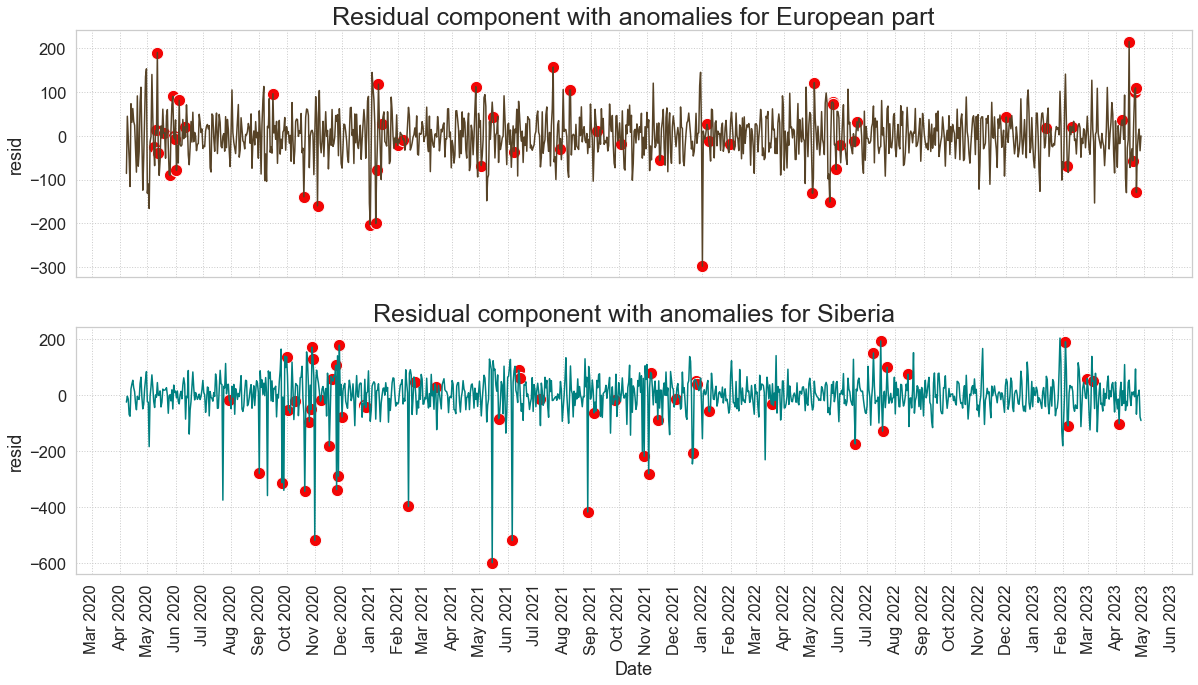

In [412]:
# plot residual component together with its anomalies
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

sns.lineplot(x=result_1.resid.index, y=result_1.resid, color="#574327", ax=ax[0])
sns.scatterplot(x=markers_1['Date'], y=markers_1['resid'], s=150, color="#f20505", ax=ax[0])
ax[0].set_title('Residual component with anomalies for European part', size=25)

ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax[1].tick_params(axis='x', rotation=90)

sns.lineplot(x=result_2.resid.index, y=result_2.resid, color="#008080", ax=ax[1])
sns.scatterplot(x=markers_2['Date'], y=markers_2['resid'], s=150, color="#f20505", ax=ax[1])
ax[1].set_title('Residual component with anomalies for Siberia', size=25)

plt.savefig('neighboranomalies.png', dpi=300, bbox_inches='tight')
plt.show()

## Statistical method prdiction

In [835]:
df_europe = pd.read_excel("buyers1.xls")

# process the dataframe and leave only column "Price"
df_europe['Price'] = df_europe['EPIPE']
df_europe['Date'] = pd.to_datetime(df_europe['Date'], dayfirst=True)
df_europe = df_europe[['Date', 'Price']]
df_europe.set_index("Date", inplace=True)

# add to the dataframe anomalies detected with statistical mehtod
df_europe['Anomaly'] = stat_anom_europe['label']

# change anomalies' column values so that they were equal to 1 and 0 otherwise
df_europe["Anomaly"] =df_europe["Anomaly"].fillna(0).astype(int)
df_europe["Anomaly"] = df_europe["Anomaly"].apply(lambda x: 1 if x != 0 else 0)

df_europe["Mean"] = df_europe["Price"].rolling(30, center=True).mean()
df_europe.head()

,Price,Anomaly,Mean
Date,,,
2020-04-05,1136.09,0,NaN
2020-04-06,1279.86,0,NaN
2020-04-07,1121.92,0,NaN
2020-04-08,1060.13,0,NaN
2020-04-09,1184.06,0,NaN


In [836]:
df_europe["Price_cleaned"] = df_europe["Price"].copy()
df_europe.loc[df_europe["Anomaly"] == 1, "Price_cleaned"] = df_europe.loc[df_europe["Anomaly"] == 1, "Mean"]
df_europe.head()

,Price,Anomaly,Mean,Price_cleaned
Date,,,,
2020-04-05,1136.09,0,NaN,1136.09
2020-04-06,1279.86,0,NaN,1279.86
2020-04-07,1121.92,0,NaN,1121.92
2020-04-08,1060.13,0,NaN,1060.13
2020-04-09,1184.06,0,NaN,1184.06


In [837]:
# dataframe split on train dataset and test dataset
train, test = df_europe[:-10], df_europe[-10:]

In [838]:
# train model and prediction with anomalies
model = ExponentialSmoothing(train["Price"], trend="add", seasonal="add").fit(optimized=True)
preds = model.forecast(len(test))
mean_squared_error(test["Price"], preds)

C:\Users\sndbo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


3633.5293810700045

In [804]:
# train model and prediction without anomalies
model = ExponentialSmoothing(train["Price_cleaned"], trend="add", seasonal="add").fit(optimized=True)
preds = model.forecast(len(test))
mean_squared_error(test["Price_cleaned"], preds)

C:\Users\sndbo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


4398.469608567914

In [805]:
df_siberia = pd.read_excel("buyers2.xls")

# process the dataframe and leave only column "Price"
df_siberia['Price'] = df_siberia['EPIPE']
df_siberia['Date'] = pd.to_datetime(df_siberia['Date'], dayfirst=True)
df_siberia = df_siberia[['Date', 'Price']]
df_siberia.set_index("Date", inplace=True)

# add to the dataframe anomalies detected with statistical mehtod
df_siberia['Anomaly'] = stat_anom_siberia['label']

# change anomalies' column values so that they were equal to 1 and 0 otherwise
df_siberia["Anomaly"] =df_siberia["Anomaly"].fillna(0).astype(int)
df_siberia["Anomaly"] = df_siberia["Anomaly"].apply(lambda x: 1 if x != 0 else 0)

df_siberia["Mean"] = df_siberia["Price"].rolling(30, center=True).mean()
df_siberia.head()

,Price,Anomaly,Mean
Date,,,
2020-04-05,1030.62,0,NaN
2020-04-06,1026.38,0,NaN
2020-04-07,959.70,0,NaN
2020-04-08,888.51,0,NaN
2020-04-09,887.76,0,NaN


In [806]:
df_siberia["Price_cleaned"] = df_siberia["Price"].copy()
df_siberia.loc[df_siberia["Anomaly"] == 1, "Price_cleaned"] = df_siberia.loc[df_siberia["Anomaly"] == 1, "Mean"]
df_siberia.head()

,Price,Anomaly,Mean,Price_cleaned
Date,,,,
2020-04-05,1030.62,0,NaN,1030.62
2020-04-06,1026.38,0,NaN,1026.38
2020-04-07,959.70,0,NaN,959.70
2020-04-08,888.51,0,NaN,888.51
2020-04-09,887.76,0,NaN,887.76


In [807]:
# dataframe split on train dataset and test datset
train, test = df_siberia[:-10], df_siberia[-10:]

In [808]:
# train model and prediction with anomalies
model = ExponentialSmoothing(train["Price"], trend="add", seasonal="add").fit(optimized=True)
preds = model.forecast(len(test))
mean_squared_error(test["Price"], preds)

C:\Users\sndbo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


4982.26901232768

In [809]:
# train model and prediction without anomalies
model = ExponentialSmoothing(train["Price_cleaned"], trend="add", seasonal="add").fit(optimized=True)
preds = model.forecast(len(test))
mean_squared_error(test["Price_cleaned"], preds)

C:\Users\sndbo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


4937.09408101754

## Isolation Forest method

In [810]:
df_europe = pd.read_excel("buyers1.xls")

# process the dataframe and leave only column "Price"
df_europe['Price'] = df_europe['EPIPE']
df_europe['Date'] = pd.to_datetime(df_europe['Date'], dayfirst=True)
df_europe = df_europe[['Date', 'Price']]
df_europe.set_index("Date", inplace=True)

# #add to the dataframe anomalies detected with statistical mehtod
df_europe['Anomaly'] = forest_anom_europe

# change anomalies' column values so that they were equal to 1 and 0 otherwise
df_europe["Anomaly"] = df_europe["Anomaly"].apply(lambda x: 1 if x == -1 else 0)

df_europe["Mean"] = df_europe["Price"].rolling(30, center=True).mean()
df_europe['Mean_15'] = df_europe['Price'].rolling(15, center=True).mean()
df_europe.loc[df_europe['Mean'].isna(), 'Mean'] = df_europe.loc[df_europe['Mean'].isna(), 'Mean_15']

df_europe.head()

,Price,Anomaly,Mean,Mean_15
Date,,,,
2020-04-05,1136.09,0,NaN,NaN
2020-04-06,1279.86,0,NaN,NaN
2020-04-07,1121.92,0,NaN,NaN
2020-04-08,1060.13,0,NaN,NaN
2020-04-09,1184.06,0,NaN,NaN


In [811]:
df_europe["Price_cleaned"] = df_europe["Price"].copy()
df_europe.loc[df_europe["Anomaly"] == 1, "Price_cleaned"] = df_europe.loc[df_europe["Anomaly"] == 1, "Mean"]
df_europe.head()

,Price,Anomaly,Mean,Mean_15,Price_cleaned
Date,,,,,
2020-04-05,1136.09,0,NaN,NaN,1136.09
2020-04-06,1279.86,0,NaN,NaN,1279.86
2020-04-07,1121.92,0,NaN,NaN,1121.92
2020-04-08,1060.13,0,NaN,NaN,1060.13
2020-04-09,1184.06,0,NaN,NaN,1184.06


In [812]:
# dataframe split on train dataset and test dataset
train, test = df_europe[:-10], df_europe[-10:]

In [813]:
# train model and prediction with anomalies
model = ExponentialSmoothing(train["Price"], trend="add", seasonal="add").fit(optimized=True)
preds = model.forecast(len(test))
mean_squared_error(test["Price"], preds)

C:\Users\sndbo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


3633.5293810700045

In [814]:
# train model and prediction without anomalies
model = ExponentialSmoothing(train["Price_cleaned"], trend="add", seasonal="add").fit(optimized=True)
preds = model.forecast(len(test))
mean_squared_error(test["Price_cleaned"], preds)

C:\Users\sndbo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2216.4082822448063

In [815]:
df_siberia = pd.read_excel("buyers2.xls")

# process the dataframe and leave only column "Price"
df_siberia['Price'] = df_siberia['EPIPE']
df_siberia['Date'] = pd.to_datetime(df_siberia['Date'], dayfirst=True)
df_siberia = df_siberia[['Date', 'Price']]
df_siberia.set_index("Date", inplace=True)

# #add to the dataframe anomalies detected with statistical mehtod
df_siberia['Anomaly'] = forest_anom_siberia

# change anomalies' column values so that they were equal to 1 and 0 otherwise
df_siberia["Anomaly"] = df_siberia["Anomaly"].apply(lambda x: 1 if x == -1 else 0)

df_siberia["Mean"] = df_siberia["Price"].rolling(30, center=True).mean()
df_siberia['Mean_15'] = df_siberia['Price'].rolling(15, center=True).mean()
df_siberia.loc[df_siberia['Mean'].isna(), 'Mean'] = df_siberia.loc[df_siberia['Mean'].isna(), 'Mean_15']

df_siberia.head()

,Price,Anomaly,Mean,Mean_15
Date,,,,
2020-04-05,1030.62,0,NaN,NaN
2020-04-06,1026.38,0,NaN,NaN
2020-04-07,959.70,0,NaN,NaN
2020-04-08,888.51,0,NaN,NaN
2020-04-09,887.76,0,NaN,NaN


In [816]:
df_siberia["Price_cleaned"] = df_siberia["Price"].copy()
df_siberia.loc[df_siberia["Anomaly"] == 1, "Price_cleaned"] = df_siberia.loc[df_siberia["Anomaly"] == 1, "Mean"]
df_siberia.head()

,Price,Anomaly,Mean,Mean_15,Price_cleaned
Date,,,,,
2020-04-05,1030.62,0,NaN,NaN,1030.62
2020-04-06,1026.38,0,NaN,NaN,1026.38
2020-04-07,959.70,0,NaN,NaN,959.70
2020-04-08,888.51,0,NaN,NaN,888.51
2020-04-09,887.76,0,NaN,NaN,887.76


In [817]:
# dataframe split on train dataset and test dataset
train, test = df_siberia[:-10], df_siberia[-10:]

In [818]:
# train model and prediction with anomalies
model = ExponentialSmoothing(train["Price"], trend="add", seasonal="add").fit(optimized=True)
preds = model.forecast(len(test))
mean_squared_error(test["Price"], preds)

C:\Users\sndbo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


4982.26901232768

In [819]:
# train model and prediction without anomalies
model = ExponentialSmoothing(train["Price_cleaned"], trend="add", seasonal="add").fit(optimized=True)
preds = model.forecast(len(test))
mean_squared_error(test["Price_cleaned"], preds)

C:\Users\sndbo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


4881.232648438678

## K-means algorithm

In [820]:
df_europe = pd.read_excel("buyers1.xls")

# process the dataframe and leave only column "Price"
df_europe['Price'] = df_europe['EPIPE']
df_europe['Date'] = pd.to_datetime(df_europe['Date'], dayfirst=True)
df_europe = df_europe[['Date', 'Price']]
df_europe.set_index("Date", inplace=True)

# add to the dataframe anomalies detected with statistical mehtod
df_europe['Anomaly'] = kmeans_anom_europe

# change anomalies' column values so that they were equal to 1 and 0 otherwise
df_europe["Anomaly"] = (df_europe["Anomaly"] == 1).astype(int)

df_europe["Mean"] = df_europe["Price"].rolling(30, center=True).mean()
df_europe["Mean_30"] = df_europe["Price"].rolling(30).mean()
df_europe.loc[df_europe['Mean'].isna(), 'Mean'] = df_europe.loc[df_europe['Mean'].isna(), 'Mean_30']

df_europe.head()

,Price,Anomaly,Mean,Mean_30
Date,,,,
2020-04-05,1136.09,0,NaN,NaN
2020-04-06,1279.86,0,NaN,NaN
2020-04-07,1121.92,0,NaN,NaN
2020-04-08,1060.13,0,NaN,NaN
2020-04-09,1184.06,0,NaN,NaN


In [821]:
# create the new column for cleaned from anomalies price
df_europe["Price_cleaned"] = df_europe["Price"].copy()
df_europe.loc[df_europe["Anomaly"] == 1, "Price_cleaned"] = df_europe.loc[df_europe["Anomaly"] == 1, "Mean"]
df_europe.head()

,Price,Anomaly,Mean,Mean_30,Price_cleaned
Date,,,,,
2020-04-05,1136.09,0,NaN,NaN,1136.09
2020-04-06,1279.86,0,NaN,NaN,1279.86
2020-04-07,1121.92,0,NaN,NaN,1121.92
2020-04-08,1060.13,0,NaN,NaN,1060.13
2020-04-09,1184.06,0,NaN,NaN,1184.06


In [822]:
# dataframe split on train dataset and test dataset
train, test = df_europe[:-10], df_europe[-10:]

In [823]:
# train model and prediction with anomalies
model = ExponentialSmoothing(train["Price"], trend="add", seasonal="add").fit(optimized=True)
preds = model.forecast(len(test))
mean_squared_error(test["Price"], preds)

C:\Users\sndbo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


3633.5293810700045

In [824]:
# train model and prediction without anomalies
model = ExponentialSmoothing(train["Price_cleaned"], trend="add", seasonal="add").fit(optimized=True)
preds = model.forecast(len(test))
mean_squared_error(test["Price_cleaned"], preds)

C:\Users\sndbo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


21610.188073816957

In [825]:
df_siberia = pd.read_excel("buyers2.xls")

# process the dataframe and leave only column "Price"
df_siberia['Price'] = df_siberia['EPIPE']
df_siberia['Date'] = pd.to_datetime(df_siberia['Date'], dayfirst=True)
df_siberia = df_siberia[['Date', 'Price']]
df_siberia.set_index("Date", inplace=True)

# add to the dataframe anomalies detected with statistical mehtod
df_siberia['Anomaly'] = kmeans_anom_siberia

# change anomalies' column values so that they were equal to 1 and 0 otherwise
df_siberia["Anomaly"] = (df_siberia["Anomaly"] == 1).astype(int)

df_siberia["Mean"] = df_siberia["Price"].rolling(30, center=True).mean()
df_siberia["Mean_30"] = df_siberia["Price"].rolling(30).mean()
df_siberia.loc[df_siberia['Mean'].isna(), 'Mean'] = df_siberia.loc[df_siberia['Mean'].isna(), 'Mean_30']

df_europe.head()

,Price,Anomaly,Mean,Mean_30,Price_cleaned
Date,,,,,
2020-04-05,1136.09,0,NaN,NaN,1136.09
2020-04-06,1279.86,0,NaN,NaN,1279.86
2020-04-07,1121.92,0,NaN,NaN,1121.92
2020-04-08,1060.13,0,NaN,NaN,1060.13
2020-04-09,1184.06,0,NaN,NaN,1184.06


In [826]:
# create the new column for cleaned from anomalies price
df_siberia["Price_cleaned"] = df_siberia["Price"].copy()
df_siberia.loc[df_siberia["Anomaly"] == 1, "Price_cleaned"] = df_siberia.loc[df_siberia["Anomaly"] == 1, "Mean"]
df_siberia.head()

,Price,Anomaly,Mean,Mean_30,Price_cleaned
Date,,,,,
2020-04-05,1030.62,0,NaN,NaN,1030.62
2020-04-06,1026.38,0,NaN,NaN,1026.38
2020-04-07,959.70,0,NaN,NaN,959.70
2020-04-08,888.51,0,NaN,NaN,888.51
2020-04-09,887.76,0,NaN,NaN,887.76


In [827]:
# dataframe split on train dataset and test dataset
train, test = df_siberia[:-10], df_siberia[-10:]

In [828]:
# train model and prediction with anomalies
model = ExponentialSmoothing(train["Price"], trend="add", seasonal="add").fit(optimized=True)
preds = model.forecast(len(test))
mean_squared_error(test["Price"], preds)

C:\Users\sndbo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


4982.26901232768

In [829]:
# train model and prediction without anomalies
model = ExponentialSmoothing(train["Price_cleaned"], trend="add", seasonal="add").fit(optimized=True)
preds = model.forecast(len(test))
mean_squared_error(test["Price_cleaned"], preds)

C:\Users\sndbo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


4550.1541166882735

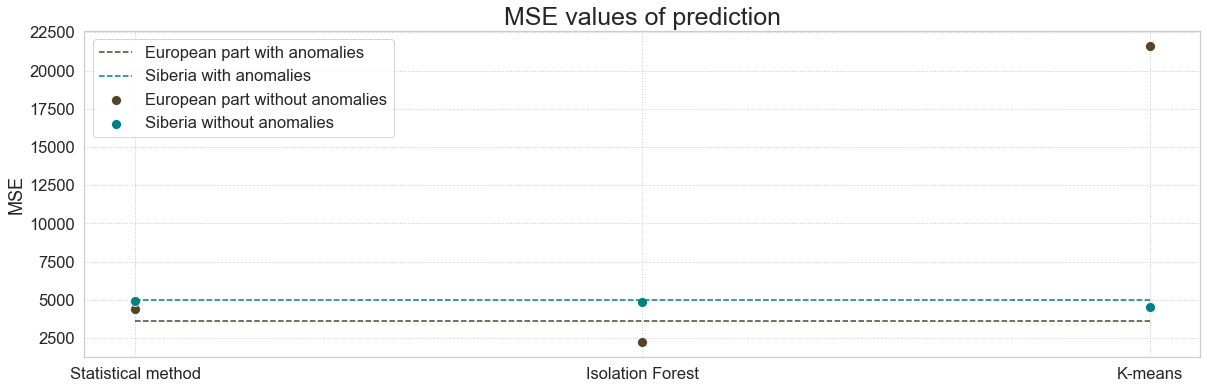

In [859]:
fig, ax = plt.subplots()

sns.lineplot(x=['Statistical method', 'Isolation Forest', 'K-means'],
             y=[3633, 3633, 3633], label="European part with anomalies",
            color='#544327', linestyle='dashed', ax=ax)
# sns.lineplot(x=['Statistical method', 'Isolation Forest', 'K-means'],
#              y=[4398, 2216, 21610], label="European part without anomalies",
#             color='#544327', ax=ax)
sns.scatterplot(x=['Statistical method', 'Isolation Forest', 'K-means'], 
                y=[4398, 2216, 21610], label="European part without anomalies", s=100, color="#544327", ax=ax)

sns.lineplot(x=['Statistical method', 'Isolation Forest', 'K-means'],
             y=[4982, 4982, 4982], label="Siberia with anomalies",
            color='#008080', linestyle='dashed', ax=ax)
# sns.lineplot(x=['Statistical method', 'Isolation Forest', 'K-means'],
#              y=[4937, 4881, 4550], label="Siberia without anomalies",
#             color='#008080', ax=ax)
sns.scatterplot(x=['Statistical method', 'Isolation Forest', 'K-means'],
             y=[4937, 4881, 4550], label="Siberia without anomalies", s=100, color='#008080', ax=ax)

ax.set_title("MSE values of prediction", size=25)
ax.set_ylabel("MSE")

plt.savefig('mse.png', dpi=300, bbox_inches='tight')
plt.show()

In [584]:
# price comparison with and without anomalies
# fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

# ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
# ax[0].tick_params(axis='x', rotation=90)

# sns.lineplot(x=df_europe.index, y=df_europe["Price"], color="#574327", ax=ax[0])
# ax[0].set_title('Price with anomalies for European part', size=25)

# ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
# ax[1].tick_params(axis='x', rotation=90)

# sns.lineplot(x=df_europe.index, y=df_europe["Price_cleaned"], color="#574327", ax=ax[1])
# ax[1].set_title('Price without anomalies for Siberia', size=25)

# plt.show()